In [1]:
# -------------------------------------------------- #
# Author: Jiayu Yang
# Date: 15 May 2023
# File Name: [Project CD] 2D FVM Central & Upwind & Hybrid Difference Scheme
# File Description: 
#    This file aims at solving the 2D steady convection-diffusion problems using the
#    Finite Volume Method (FVM) with respectively:
#        - Central Difference Scheme
#        - Upwind Difference Scheme
#        - Hybrid Difference Scheme
#    The comparison of stability is also included.
# Web Link to Github: https://github.com/LakeYang0818/Solving-Convection-Diffusion-Problems
# -------------------------------------------------- #

In [9]:
import numpy as np
import math as m
import mpmath
import matplotlib.pyplot as plt
import sys
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator

colorinterpolation = 50
colourMap = plt.cm.jet

In [10]:
# ------------FVM Central Scheme------------
def FVM_2D_Central(a, mu, s, u0, uN, N, M):
    dx = 1 / N
    dy = 1 / M
    xmesh = list(i * dx for i in range(N + 1))
    ymesh = list(i * dy for i in range(M + 1))


    A = np.zeros(((M - 1) * (N - 1), (M - 1) * (N - 1)))
    S = np.ones(((M - 1) * (N - 1))) * s * dx
    Fw = a
    Fe = a
    Fs = a
    Fn = a
    Dw = mu / dx
    De = mu / dx
    Ds = mu / dy
    Dn = mu / dy

    X_left  = Dw + Fw / 2
    X_right = Dw - Fe / 2
    Y_left  = Ds + Fs / 2
    Y_right = Dn - Fn / 2
    XY_mid  = X_left + X_right + Y_left + Y_right
    
    # the left and right matrices components of the matrix A
    A_right = np.zeros((N - 1, N - 1))
    A_left  = np.zeros((N - 1, N - 1))
    for i in range(N - 1):
        A_right[i, i] = X_right
        A_left[i,  i] = X_left
         
    for i in range(N - 1):
        num_min = i * (N - 1)
        num_max = (i + 1) * (N - 1)

        # Left and Right Matrices
        if i == 0:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = - A_right
        elif i == N - 2:
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = - A_left
        else:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = - A_right
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = - A_left

        # Diagonal Matrices
        A_diag = np.zeros((M - 1, M - 1))        
        for j in range(M - 1):
            if j == 0:
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j + 1] = - Y_right

            elif j == M - 2:
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j - 1] = - Y_left
            else:
                A_diag[j, j - 1] = - Y_left
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j + 1] = - Y_right
        A[num_min : num_max, num_min : num_max] = A_diag

    u_FVM_2D_Central = np.zeros((N + 1, M + 1))
    u_FVM_2D_Central[1 : N, 1 : M] = np.linalg.solve(A, S).reshape((N - 1, M - 1))
    return u_FVM_2D_Central


In [11]:
# ------------FVM Upwinding Scheme------------
def FVM_2D_Upwind(a, mu, s, u0, uN, N, M):
    dx = 1 / N
    dy = 1 / M
    xmesh = list(i * dx for i in range(N + 1))
    ymesh = list(i * dy for i in range(M + 1))

    A = np.zeros(((M - 1) * (N - 1), (M - 1) * (N - 1)))
    S = np.ones(((M - 1) * (N - 1))) * s * dx
    Fw = a
    Fe = a
    Fs = a
    Fn = a
    Dw = mu / dx
    De = mu / dx
    Ds = mu / dy
    Dn = mu / dy

    X_left  = Dw + max(+ Fw, 0)
    X_right = Dw + max(- Fe, 0)
    Y_left  = Ds + max(+ Fs, 0)
    Y_right = Dn + max(- Fn, 0)
    XY_mid  = X_left + X_right + Y_left + Y_right
    
    # the left and right matrices components of the matrix A
    A_right = np.zeros((N - 1, N - 1))
    A_left  = np.zeros((N - 1, N - 1))
    for i in range(N - 1):
        A_right[i, i] = X_right
        A_left[i,  i] = X_left
         
    for i in range(N - 1):
        num_min = i * (N - 1)
        num_max = (i + 1) * (N - 1)

        # Left and Right Matrices
        if i == 0:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = - A_right
        elif i == N - 2:
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = - A_left
        else:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = - A_right
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = - A_left

        # Diagonal Matrices
        A_diag = np.zeros((M - 1, M - 1))        
        for j in range(M - 1):
            if j == 0:
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j + 1] = - Y_right

            elif j == M - 2:
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j - 1] = - Y_left
            else:
                A_diag[j, j - 1] = - Y_left
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j + 1] = - Y_right
        A[num_min : num_max, num_min : num_max] = A_diag

    u_FVM_2D_Upwind = np.zeros((N + 1, M + 1))
    u_FVM_2D_Upwind[1 : N, 1 : M] = np.linalg.solve(A, S).reshape((N - 1, M - 1))
    return u_FVM_2D_Upwind


In [12]:
# ------------FVM Hybrid Scheme------------
def FVM_2D_Hybrid(a, mu, s, u0, uN, N, M):
    dx = 1 / N
    dy = 1 / M
    xmesh = list(i * dx for i in range(N + 1))
    ymesh = list(i * dy for i in range(M + 1))

    A = np.zeros(((M - 1) * (N - 1), (M - 1) * (N - 1)))
    S = np.ones(((M - 1) * (N - 1))) * s * dx
    Fw = a
    Fe = a
    Fs = a
    Fn = a
    Dw = mu / dx
    De = mu / dx
    Ds = mu / dy
    Dn = mu / dy

    X_left  = max(+Fw, (Dw + Fw / 2), 0)
    X_right = max(-Fe, (Dw - Fe / 2), 0)
    Y_left  = max(+Fs, (Ds + Fs / 2), 0)
    Y_right = max(-Fn, (Dn - Fn / 2), 0)
    XY_mid  = X_left + X_right + Y_left + Y_right
    
    # the left and right matrices components of the matrix A
    A_right = np.zeros((N - 1, N - 1))
    A_left  = np.zeros((N - 1, N - 1))
    for i in range(N - 1):
        A_right[i, i] = X_right
        A_left[i,  i] = X_left
         
    for i in range(N - 1):
        num_min = i * (N - 1)
        num_max = (i + 1) * (N - 1)

        # Left and Right Matrices
        if i == 0:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = - A_right
        elif i == N - 2:
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = - A_left
        else:
            A[num_min : num_max, num_min + (N - 1) : num_max + (N - 1)] = - A_right
            A[num_min : num_max, num_min - (N - 1) : num_max - (N - 1)] = - A_left

        # Diagonal Matrices
        A_diag = np.zeros((M - 1, M - 1))        
        for j in range(M - 1):
            if j == 0:
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j + 1] = - Y_right

            elif j == M - 2:
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j - 1] = - Y_left
            else:
                A_diag[j, j - 1] = - Y_left
                A_diag[j,   j  ] = XY_mid
                A_diag[j, j + 1] = - Y_right
        A[num_min : num_max, num_min : num_max] = A_diag

    u_FVM_2D_Hybrid = np.zeros((N + 1, M + 1))
    u_FVM_2D_Hybrid[1 : N, 1 : M] = np.linalg.solve(A, S).reshape((N - 1, M - 1))
    return u_FVM_2D_Hybrid


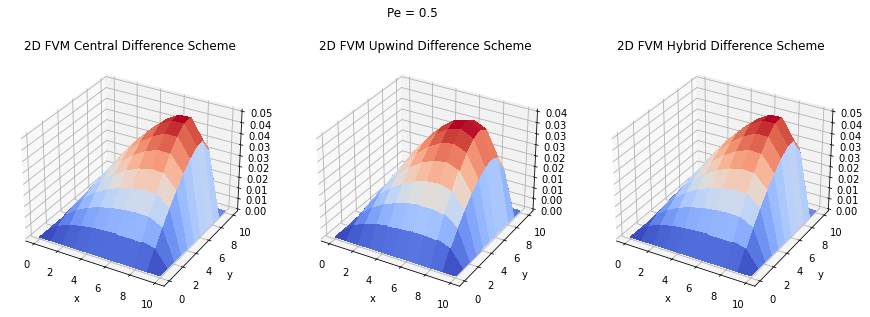

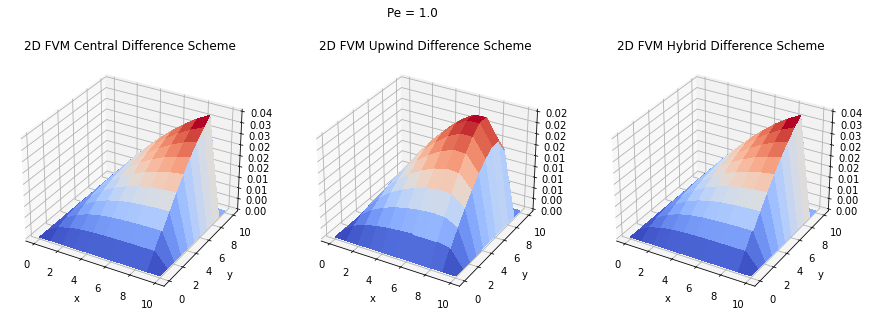

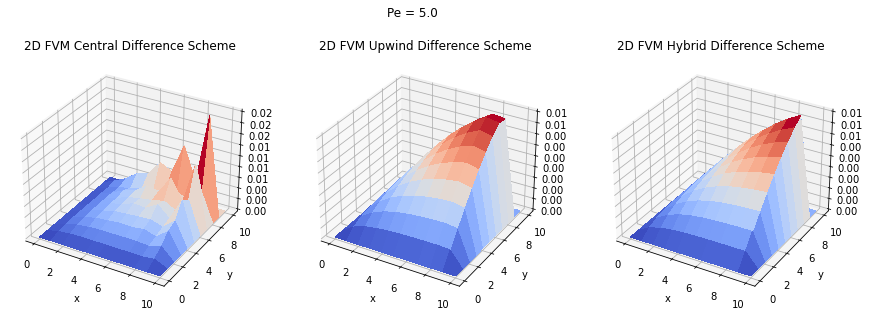

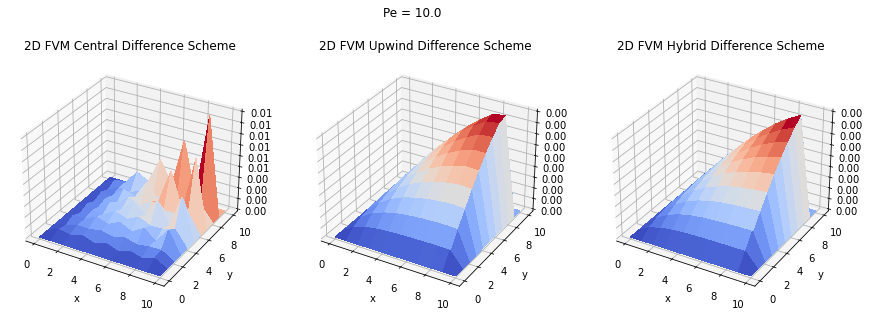

In [13]:
def Plot_3D_comparison(a, mu, s, u0, uN, N, M):
    Pe = a / (2 * N * mu)
    
    # Calculation
    FVM_cen = FVM_2D_Central(a, mu, s, u0, uN, N, M)
    FVM_upw = FVM_2D_Upwind(a, mu, s, u0, uN, N, M)
    FVM_hyb = FVM_2D_Hybrid(a, mu, s, u0, uN, N, M)
    
    FVM_cen_data = FVM_cen.reshape((N + 1, M + 1))
    FVM_upw_data = FVM_upw.reshape((N + 1, M + 1))
    FVM_hyb_data = FVM_hyb.reshape((N + 1, M + 1))
    
    # Plot 
    fig, axs = plt.subplots(1, 3, subplot_kw={"projection": "3d"}, figsize=(15, 5))
    fig.suptitle('Pe = %s'%Pe)
    x = range(N + 1)
    y = range(M + 1)
    X, Y = np.meshgrid(x, y)
    
    C1 = axs[0].plot_surface(X, Y, FVM_cen_data, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    
    C2 = axs[1].plot_surface(X, Y, FVM_upw_data, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    
    C3 = axs[2].plot_surface(X, Y, FVM_hyb_data, cmap = cm.coolwarm,
                           linewidth = 0, antialiased = False)
    
    axs[0].zaxis.set_major_locator(LinearLocator(10))
    axs[0].zaxis.set_major_formatter('{x:.02f}')
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    
    axs[1].zaxis.set_major_locator(LinearLocator(10))
    axs[1].zaxis.set_major_formatter('{x:.02f}')
    axs[1].set_xlabel('x')
    axs[1].set_ylabel('y')
    
    axs[2].zaxis.set_major_locator(LinearLocator(10))
    axs[2].zaxis.set_major_formatter('{x:.02f}')
    axs[2].set_xlabel('x')
    axs[2].set_ylabel('y')
    
    axs[0].set_title('2D FVM Central Difference Scheme')
    axs[1].set_title('2D FVM Upwind Difference Scheme')
    axs[2].set_title('2D FVM Hybrid Difference Scheme')
    
    #plt.savefig('/Users/pc/Desktop/[P2] Convection-Diffusion Problem/Images Pool/2D Comparison of FVM with different schemes at Pe = %s.png'%Pe)
    plt.show()
    
N = 10
M = 10
s = 1
mu = 1
u0 = 0
uN = 0
Pe_choice = [0.5, 1, 5, 10]
for Pe in Pe_choice:
    a = Pe * 2 * N * mu
    Plot_3D_comparison(a, mu, s, u0, uN, N, M)